In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline


In [8]:
df = pd.read_excel('../data/total_full_month.xlsx')
df.head()

,DT,cnt
0,2020-01-01,3483
1,2020-01-02,3270
2,2020-01-03,5583
3,2020-01-04,5570
4,2020-01-05,3707


In [9]:
df.describe()

,cnt
count,1035.000000
mean,2851.699517
std,1125.248221
min,1170.000000
25%,2143.500000
50%,2552.000000
75%,3244.500000
max,12195.000000


In [10]:
df['DT'] = pd.to_datetime(df['DT'])
df = df.set_index('DT')

In [11]:
df.head()

,cnt
DT,
2020-01-01,3483
2020-01-02,3270
2020-01-03,5583
2020-01-04,5570
2020-01-05,3707


<AxesSubplot:xlabel='DT'>

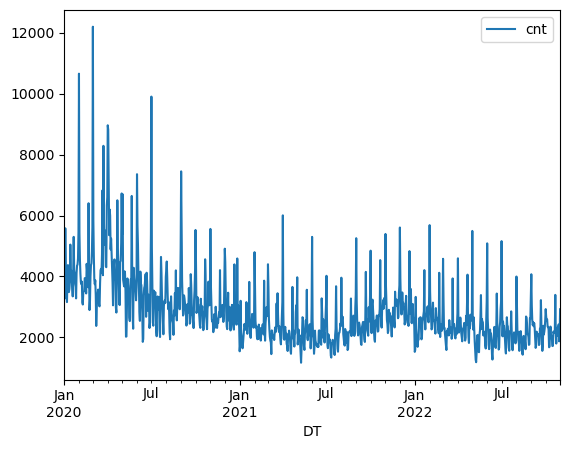

In [12]:
df.plot()

## Строим модель на базе полносвязной сети

In [13]:

std_scaler = StandardScaler()
data_std = std_scaler.fit_transform(np.array(df[['cnt']]))
df_std = pd.DataFrame(data=data_std, columns=['cnt_std'])
df_std.head()

,cnt_std
0,0.561303
1,0.371920
2,2.428461
3,2.416902
4,0.760467


In [162]:
df.describe()

,cnt
count,1035.000000
mean,2851.699517
std,1125.248221
min,1170.000000
25%,2143.500000
50%,2552.000000
75%,3244.500000
max,12195.000000


In [14]:
df_std.describe()

,cnt_std
count,1.035000e+03
mean,1.098424e-16
std,1.000483e+00
min,-1.495237e+00
25%,-6.296761e-01
50%,-2.664696e-01
75%,3.492477e-01
max,8.307338e+00


In [15]:
X = df_std.index.values.reshape(-1,1)

In [16]:
y = df_std['cnt_std'].values

## Строим модель на базе LSTM слоев

In [17]:
def split_series(sequence, step):
    """Функция для подготовки данных для подачи в LSTM слой"""
    X, y = list(), list()
    for i in range(len(sequence)):
        end = i + step
        if end > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end], sequence[end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [155]:
step = 7
X_lstm, y_lstm = split_series(y, step)
X_lstm[0], y_lstm

(array([0.56130342, 0.37192035, 2.42846055, 2.41690195, 0.76046685,
        0.51062345, 0.27411688]),
 array([ 0.93473485,  1.35351152,  0.97385624, ..., -0.87107282,
        -0.73770446,  0.0651731 ]))

In [143]:
model_lstm = keras.Sequential()
model_lstm.add(layers.LSTM(512, activation='relu', return_sequences=True, input_shape=(step, 1)))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.LSTM(394, return_sequences=True, activation='relu'))
model_lstm.add(layers.Dropout(0.4))
model_lstm.add(layers.LSTM(16, activation='relu'))
model_lstm.add(layers.Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_lstm, y_lstm, epochs=400, verbose=0)


In [144]:
y_lstm_pred = model_lstm.predict(X_lstm)

33/33 [==============================] - 1s 7ms/step


In [145]:
x_input = X_lstm[0].reshape((1, step, 1))
y_tst = model_lstm.predict(x_input)
y_tst

1/1 [==============================] - 0s 342ms/step


array([[0.95359457]], dtype=float32)

In [146]:
y_lstm_pred_list = [i[0] for i in y_lstm_pred]

In [147]:
y_lstm_pred_list = y_lstm_pred.tolist()
y_lstm_pred_list = [i[0] for i in y_lstm_pred_list]
y_lstm_pred_list[-1*step:]

[-0.4912498891353607,
 -0.6634052991867065,
 -0.4643644392490387,
 -0.36345407366752625,
 -0.7380514144897461,
 -0.7424443960189819,
 0.02310618758201599]

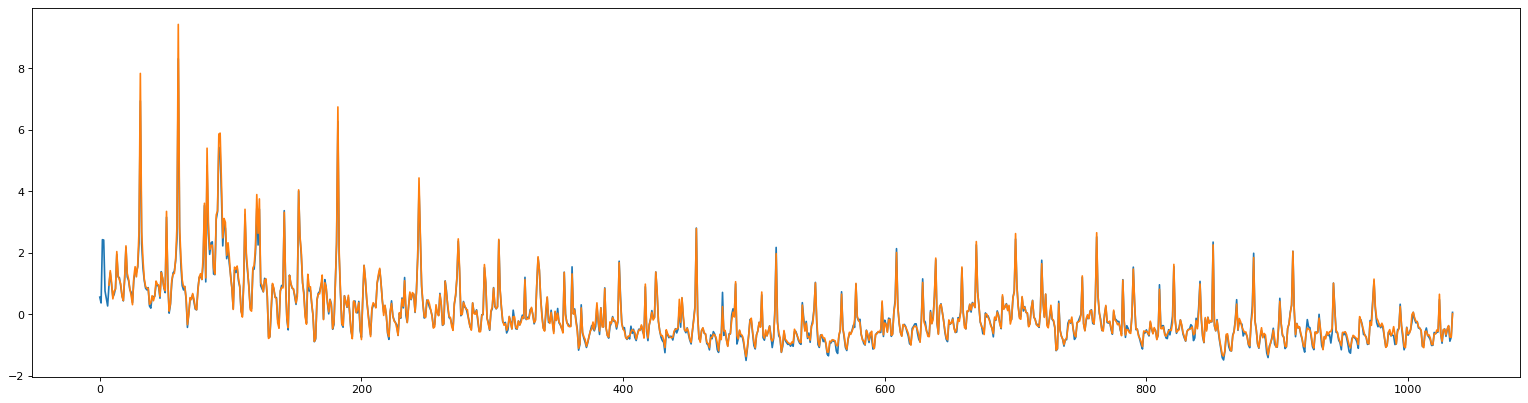

In [148]:
plt.figure(figsize=(24, 6), dpi=80)
plt.plot(X, y)
plt.plot(X[step:], y_lstm_pred_list)

In [149]:
days = 300
def future_pred(days, step, y):
    future = []
    for i in range(days):
        x = np.array(y[-1*step::]).reshape((1, step, 1))
        y_f = model_lstm.predict(x, verbose=0)[0][0]
        y.append(y_f)
        future.append(y_f)
    return future

y_ft = y_lstm_pred_list.copy()
y_future = future_pred(days, step, y_ft)





In [152]:
y

array([ 0.56130342,  0.37192035,  2.42846055, ..., -0.87107282,
       -0.73770446,  0.0651731 ])

In [150]:
X_future = [i + len(X) for i in range(days)]

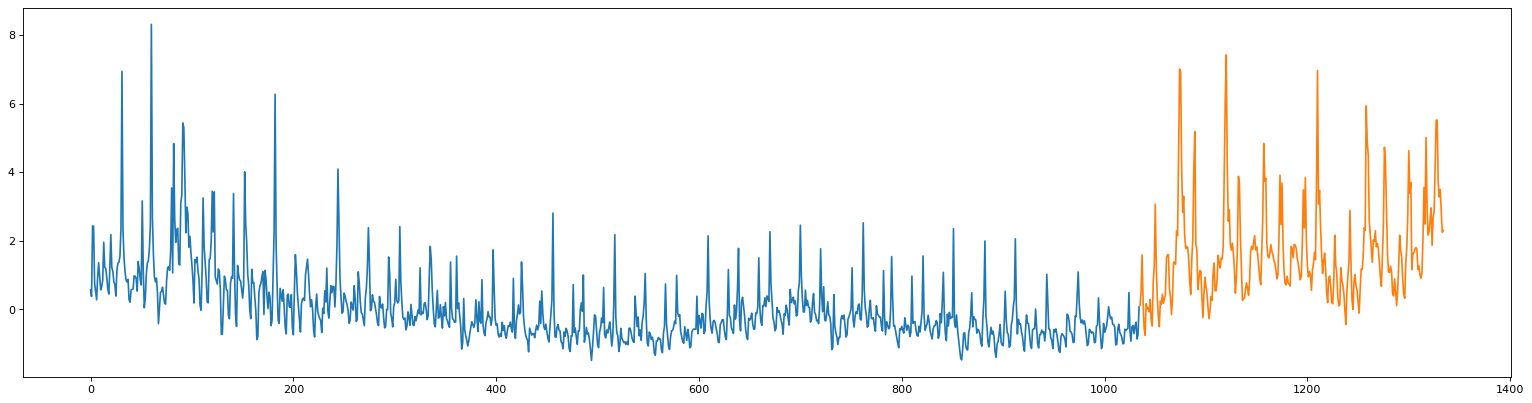

In [151]:
plt.figure(figsize=(24, 6), dpi=80)
plt.plot(X, y)
plt.plot(X_future, y_future)

In [78]:
y_future_unstd = std_scaler.inverse_transform(np.array(y_future).reshape(-1,1))


In [1196]:
model_lstm.save('model_lstm2') 

INFO:tensorflow:Assets written to: model_lstm2\assets


In [154]:
type(y_ft)

list

In [156]:
y

array([ 0.56130342,  0.37192035,  2.42846055, ..., -0.87107282,
       -0.73770446,  0.0651731 ])

In [158]:
last_y = y[-7:]
last_y, y

(array([-0.47363509, -0.71369815, -0.4896393 , -0.37849899, -0.87107282,
        -0.73770446,  0.0651731 ]),
 array([ 0.56130342,  0.37192035,  2.42846055, ..., -0.87107282,
        -0.73770446,  0.0651731 ]))

In [160]:
y

array([ 0.56130342,  0.37192035,  2.42846055, ..., -0.87107282,
       -0.73770446,  0.0651731 ])